In [1]:
file_path = "Images/"

In [4]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
from func import *
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import re
from time import time
from sklearn.decomposition import PCA
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics.cluster import adjusted_rand_score
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import KeyedVectors
import gensim.downloader as gensim_api
import gensim
import json
import cv2
import plotly.graph_objs as go
import plotly.express as px
import glob
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image_dataset_from_directory
%matplotlib inline

In [9]:
%store -r txt_clean

In [34]:
%store -r categories

In [67]:
%store -r w2v_gn300_tsne

In [79]:
%store -r all_doc_vec_gn300

In [14]:
# Load images
from PIL import Image
import cv2
# filenames = [img for img in glob.glob(path_to_images_folder + "/*.jpg")]
img_filenames = txt_clean["image"]
img_paths = [file_path + img for img in img_filenames]
img_base = [cv2.imread(img) for img in img_paths]

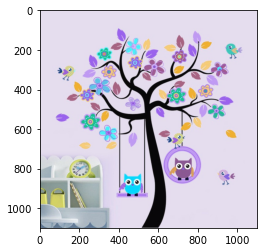

In [15]:
# Example first image
import matplotlib.pyplot as plt
plt.imshow(img_base[-1]);

In [18]:
path_example = file_path  + "55b85ea15a1536d46b7190ad6fff8ce7.jpg"
img_ex = cv2.imread(path_example)

# Convert tot grayscale and equalize
img_ex_nb = cv2.cvtColor(img_ex, cv2.COLOR_RGB2GRAY)
img_exa_nb = cv2.equalizeHist(img_ex_nb)

# ORB processing
orb_test = cv2.ORB_create()
kp, des = orb_test.detectAndCompute(img_ex_nb, None)
img_ex_kp = cv2.drawKeypoints(img_ex_nb, kp, np.array([]), (0, 0, 255), 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualization of keypoints
#cv2.namedWindow('ORB_image', cv2.WINDOW_NORMAL)
#cv2.resizeWindow('ORB_image', 1000, 1000)
#cv2.imshow('ORB_processing_example', img_ex_kp)
#cv2.waitKey()
#cv2.destroyAllWindows()

# Image descriptors
des

array([[207,  81, 199, ..., 191,  41,  80],
       [ 53, 255, 219, ..., 251, 240, 177],
       [ 88,  60,  63, ..., 194, 230,  59],
       ...,
       [ 40, 233, 118, ..., 156, 206, 170],
       [175, 168, 243, ..., 205,  39, 246],
       [ 93, 191, 146, ..., 196, 236, 125]], dtype=uint8)

In [19]:
# Preprocess images: grayscale and equalize
img_orb = [cv2.cvtColor(img_base[i], cv2.COLOR_RGB2GRAY) for i in range(len(img_base))]
img_orb = [cv2.equalizeHist(img_orb[i]) for i in range(len(img_orb))]

In [23]:
def ORB_hist_tsne(images, kmeans_n_clusters, nfeatures=500, WTA_K=2, scale_factor=1.2, k="sqrt", 
    batch_size=1024, mbatch_max_iter=1000, n_comp=2, method="barnes_hut", init="pca", n_jobs=-2, 
    learning_rate=200, perplexity=30, random_state=None):
    """
    Use ORB algorithm to extract descriptors from input images.
    Group the descriptors with MiniBatch KMeans.
    Make histograms from the clustering results.
    Reduce histogram dimensions with t-SNE.
    Use t-SNE results in a KMeans to cluster images.
    Return the images histograms, the kmeans object and t-SNE results.

    images: iterable containing preprocessed images
    kmeans_n_clusters (int): number of categories to use for images clustering

    ORB parameters
    nfeatures (int): max number of features to select per image
    WTA_K (int): number of points that produce each element of the oriented BRIEF descriptor.
    scale_factor (float): pyramid decimation ratio (> 1)

    MiniBatch KMeans parameters:
    k: "sqrt", "10-times" or int. Number of clusters. If "sqrt", take the squared root of the 
        number of descriptors. If "10-time", take 10 times the number of image categories. 
        Or specify number of clusters (int).
    batch_size (int): MiniBatch size
    mbatch_max_iter (int): Max number of iterations

    t-SNE parameters
    n_comp (int): number of components
    method (str): "barnes_hut" (by default) or "exact"
    init (str): initialisation, default is "pca"
    n_jobs (int): The number of parallel jobs to run for neighbors search.
    learning_rate (int): Usually in the range [10.0, 1000.0].
    perplexity (int): Related to the number of nearest neighbors that is used in other 
    manifold learning algorithms. Usually in the range [5.0, 50.0].
    """

    # Create ORB object
    orb = cv2.ORB_create(nfeatures=nfeatures, WTA_K=WTA_K, scaleFactor=scale_factor)

    # Get descriptors in an array, each line being a descriptor
    _, des = orb.detectAndCompute(images[0], None)
    for i in range(1, len(images)):
        _, des_new = orb.detectAndCompute(images[i], None)
        des = np.vstack([des, des_new])
    
    print(f"We have a total of {des.shape[0]} descriptors. Each descriptor is a vector with {des.shape[1]} values.")

    # Select number of clusters
    if k=="sqrt":
        k = int(round(np.sqrt(len(des))))
    if k=="10-times":
        k = 10 * kmeans_n_clusters
    if type(k) is int:
        pass
    
    print(f"We will use {k} clusters to group the descriptors.")
    
    # Using Mini Batch KMeans to cluster the descriptors
    t0 = time()
    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, max_iter=mbatch_max_iter, random_state=random_state).fit(des)
    t1 = time()-t0
    print(f"Mini Batch KMeans fit time : {t1:.2f}s.")

    # Make an histogram for each image containing the number of descriptors attributed to each clusters
    histograms = np.zeros((len(images), k))

    # For each image
    for i in range(len(images)):

        img_hist = np.zeros(k)
        # Get descriptors, predict their cluster
        _, img_des = orb.detectAndCompute(images[i], None)
        nb_des = len(img_des)
        clusters_des = mb_kmeans.predict(img_des)
        if nb_des==0:
            print(f"No image descriptors at image {i}")
        # For each descriptor, increases the corresponding cluster count by one
        # Normalize by the number of descriptors of the image (in case it varies between images) 
        for j in clusters_des:
            img_hist[j] += 1/nb_des

        # Replace the zeros by the image histogram in the numpy array
        histograms[i] = img_hist
    
    print(f"Computed {histograms.shape[0]} histograms of length {histograms.shape[1]}.")
    
    # t_SNE dimensions reduction and visualization
    tsne_results = TSNE(n_components=n_comp, init=init, method=method, n_jobs=n_jobs, random_state=random_state, 
        learning_rate=learning_rate, perplexity=perplexity).fit_transform(histograms)
    
    # Kmeans on t-SNE results
    t0 = time()
    kmeans = KMeans(n_clusters=kmeans_n_clusters,random_state=random_state).fit(tsne_results)
    t1 = time()-t0
    print(f"KMeans fit time : {t1:.2f}s.")

    # Plot silhouettes
    fig, ax = plt.subplots(figsize=(7, 6))
    visualizer = SilhouetteVisualizer(KMeans(kmeans_n_clusters, random_state=0),
        title=f'Silhouette plot KMeans with {kmeans_n_clusters} clusters')
    visualizer.fit(tsne_results)
    visualizer.finalize()

    # Improve t-SNE results visualization and add KMeans labels
    tsne_results = pd.DataFrame(tsne_results)
    names_col = {}
    names = ["axis_1", "axis_2", "axis_3", "axis_4", "axis_5", "axis_6", "axis_7", "axis_8", "axis_9", "axis_10"]
    for i, name in enumerate(names):
        names_col[i] = name
    tsne_results.rename(columns=names_col, inplace=True)
    tsne_results["kmeans_labels"] = kmeans.labels_

    # Plot t-SNE results with KMeans labels
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.scatterplot(ax=ax, x=tsne_results["axis_1"], y=tsne_results["axis_2"], hue=tsne_results["kmeans_labels"], palette=sns.color_palette("husl", 7))
    ax.set_title("t-SNE results from matrix of bag of visual words features (ORB)")
    ax.set_xlabel("t-SNE first axis")
    ax.set_ylabel("t-SNE second axis")
    ax.legend();

    return histograms, kmeans, tsne_results


In [24]:
def comparison_graph_categories_cv(tsne_results, true_labels, n_comp_tsne, categories, kmeans_labels_names, 
    kmeans_centroids=None):
    """
    """
    if n_comp_tsne>10:
        print("Too many t-SNE axis!")

    axis_names = ["axis_1", "axis_2", "axis_3", "axis_4", "axis_5", "axis_6", "axis_7", "axis_8","axis_9", "axis_10"]
    cols_kmeans = axis_names[:n_comp_tsne] + ["kmeans_labels"]
    cols_truecat = axis_names[:n_comp_tsne] + ["cat"]
    short_names = ["furnishing", "baby", "watches", "decor", "kitchen", "beauty", "computers"]

    # Add true labels and KMeans labels names to t-SNE results dataframe
    tsne_results["kmeans_labels_names"] = kmeans_labels_names
    tsne_results["cat"] = true_labels

    # Make dict according to true categories and KMeans labelling for plotting
    tsne_categorized = {}
    kmeans_labels_dict = {}
    
    for short_name, long_name in zip(short_names, categories):
        tsne_categorized[short_name] = tsne_results[tsne_results["cat"]==long_name][cols_truecat]

    for short_name, long_name  in zip(short_names, categories):
        kmeans_labels_dict[short_name] = tsne_results[tsne_results["kmeans_labels_names"]==long_name][cols_kmeans]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    datas_p1 = [tsne_categorized["furnishing"], tsne_categorized["baby"], tsne_categorized["watches"], tsne_categorized["decor"], 
        tsne_categorized["kitchen"], tsne_categorized["beauty"], tsne_categorized["computers"]]
    datas_p2 = [kmeans_labels_dict["furnishing"], kmeans_labels_dict["baby"], kmeans_labels_dict["watches"], kmeans_labels_dict["decor"], 
        kmeans_labels_dict["kitchen"], kmeans_labels_dict["beauty"], kmeans_labels_dict["computers"]]
    colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

    for data, color, label in zip(datas_p1, colors, categories):
        ax1.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
    ax1.set_title(f't-SNE on {n_comp_tsne} axis, true labels')
    ax1.set_xlabel('Axis 1')
    ax1.set_ylabel('Axis 2')
    ax1.legend()

    for data, color, label in zip(datas_p2, colors, categories):
        ax2.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
    if kmeans_centroids is not None:
        ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="+", color="black", 
            linewidth=2, s=150, zorder=3, label="KMeans centroid")
    ax2.set_title(f't-SNE on {n_comp_tsne} axis, KMeans labels')
    ax2.set_xlabel('Axis 1')
    ax2.set_ylabel('Axis 2')
    ax2.legend();

In [25]:
results_computer_vision =  txt_clean[["image", "category_tree1"]].copy()

#### With basic parameters

We have a total of 520321 descriptors. Each descriptor is a vector with 32 values.
We will use 721 clusters to group the descriptors.
Mini Batch KMeans fit time : 84.72s.
Computed 1050 histograms of length 721.
KMeans fit time : 0.25s.


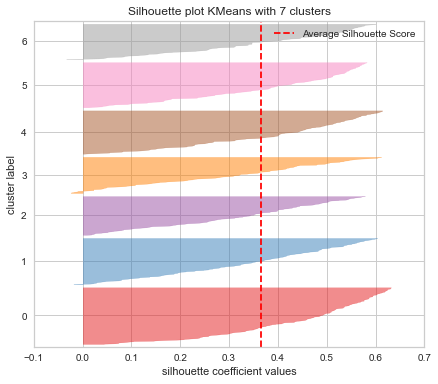

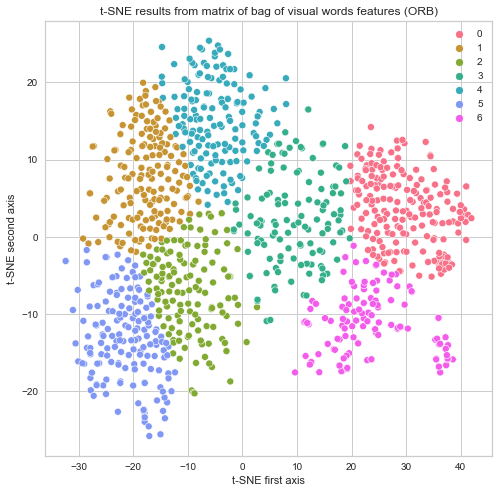

In [26]:
histograms_orb_base, kmeans_orb_base, tsne_results_orb_base = ORB_hist_tsne(img_orb, 7, random_state=0)

Example of the histogram of the first image :

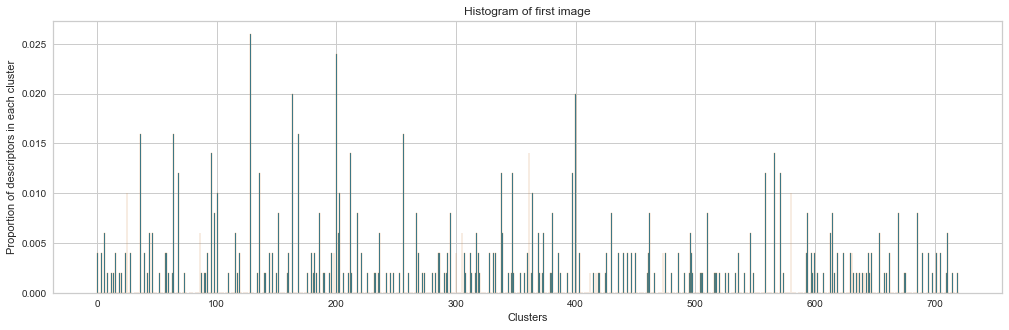

In [27]:
fig, ax = plt.subplots(figsize=(17,5))

ax.bar(x=range(0,721), height=histograms_orb_base[0], edgecolor="peru")
ax.set_title("Histogram of first image")
ax.set_xlabel("Clusters")
ax.set_ylabel("Proportion of descriptors in each cluster");

In [29]:
%store -r categories_comparison

no stored variable or alias categories_comparison


In [31]:
from new import *

In [35]:
def tsne_categories(data, true_labels, n_components=2, init="pca", learning_rate=200, perplexity=30, n_jobs=-2, random_state=0):
    """
    Perform a t-SNE dimensions reduction and display the 2D representation with products colored by their true categories.
    Limited to a maximum of 10 t-SNE axis.
    Take in input the data, true labels of categories, and main t-SNE parameters.
    Return a dataframe with coordinates along the t-SNE axis and true categories, and a dictionary of dataframes by categories.
    """
    if n_components>10:
        print("Too many t-SNE axis.")
    
    tsne_result = TSNE(n_components=n_components, init=init, n_jobs=n_jobs, random_state=random_state, 
        learning_rate=learning_rate, perplexity=perplexity).fit_transform(data)
    
    # Convert to dataframe, add true categories:
    names_col = {}
    names = ["axis_1", "axis_2", "axis_3", "axis_4", "axis_5", "axis_6", "axis_7", "axis_8", "axis_9", "axis_10"]
    for i, name in zip(range(n_components), names):
        names_col[i] = name
    tsne_df = pd.DataFrame(tsne_result)
    tsne_df.rename(columns=names_col, inplace=True)
    tsne_df["cat"] = true_labels

    # Select categories for plotting
    tsne_furnishing = tsne_df[tsne_df["cat"]=="Home Furnishing"]
    tsne_baby = tsne_df[tsne_df["cat"]=="Baby Care"]
    tsne_watches = tsne_df[tsne_df["cat"]=="Watches"]
    tsne_decor = tsne_df[tsne_df["cat"]=="Home Decor & Festive Needs"]
    tsne_kitchen = tsne_df[tsne_df["cat"]=="Kitchen & Dining"]
    tsne_beauty = tsne_df[tsne_df["cat"]=="Beauty and Personal Care"]
    tsne_computers = tsne_df[tsne_df["cat"]=="Computers"]

    tsne_categorized = {"furnishing":tsne_furnishing, "baby":tsne_baby, "watches":tsne_watches, 
        "decor":tsne_decor, "kitchen":tsne_kitchen, "beauty":tsne_beauty, "computers":tsne_computers}

    # Plot t-SNE
    fig, ax = plt.subplots(figsize=(8, 8))

    datas = [tsne_furnishing, tsne_baby, tsne_watches, tsne_decor, tsne_kitchen, tsne_beauty, tsne_computers]
    colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

    for data, color, label in zip(datas, colors, categories):
        ax.scatter(x=data["axis_1"], y=data["axis_2"], color=color, label=label)

    ax.set_title("t-SNE results from matrix of bag of words features")
    ax.set_xlabel("t-SNE first axis")
    ax.set_ylabel("t-SNE second axis")
    ax.legend();

    # if 3 components, add a 3d plot:
    if n_components==3:
        fig = plt.figure(figsize=(9, 9), tight_layout=True)
        ax = fig.add_subplot(projection='3d')

        datas = [tsne_furnishing, tsne_baby, tsne_watches, tsne_decor, tsne_kitchen, tsne_beauty, tsne_computers]
        colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

        for data, color, label in zip(datas, colors, categories):
            ax.scatter(data["axis_1"], data["axis_2"], data["axis_3"], color=color, label=label)

        ax.set_title("t-SNE results from features")
        ax.set_xlabel("t-SNE first axis")
        ax.set_ylabel("t-SNE second axis")
        ax.set_zlabel("t-SNE third axis")
        ax.legend();

    return tsne_df, tsne_categorized

In [38]:
def clusters_to_true_labels(df, col_kmeans_labels, new_col_name, ordered_list_categories):
    """
    Create a new column containing the named categories instead of the numbered clusters.
    Works with 7 categories (so clusters numbered from 0 to 6).
    Take in input a dataframe, the column name (str) containing the clustering labels (numbers), 
    the name of the new column (str) to create and a list containing the categories names corresponding to 
    clusters 0 to 6 (in the right order).
    """
    conditions = [df[col_kmeans_labels]==0, df[col_kmeans_labels]==1, 
    df[col_kmeans_labels]==2, df[col_kmeans_labels]==3, df[col_kmeans_labels]==4, 
    df[col_kmeans_labels]==5, df[col_kmeans_labels]==6]

    df[new_col_name] = np.select(conditions, ordered_list_categories)

In [39]:
def comparison_graph_categories(tsne_results, tsne_results_cat, n_comp_tsne, categories, 
    kmeans_labels_names, kmeans_centroids=None):
    """
    Compare true and predicted labels on a t-SNE graph.
    Take in input the t-SNE results from clustering, a dictionary of true categories, 
    the number of t-SNE components used, a list of true categories, the clustering labels,
    and optionaly the clustering centroids.
    Return a matplotlib graph.
    """
    if n_comp_tsne>10:
        print("Too many t-SNE axis!")

    axis_names = ["axis_1", "axis_2", "axis_3", "axis_4", "axis_5", "axis_6", "axis_7", "axis_8","axis_9", "axis_10"]
    cols = axis_names[:n_comp_tsne] + ["kmeans_labels"]

    tsne_results["kmeans_labels"] = kmeans_labels_names
    kmeans_labels_dict = {}
    kmeans_labels_dict["furnishing"] = tsne_results[tsne_results["kmeans_labels"]=="Home Furnishing"][cols]
    kmeans_labels_dict["baby"] = tsne_results[tsne_results["kmeans_labels"]=="Baby Care"][cols]
    kmeans_labels_dict["watches"] = tsne_results[tsne_results["kmeans_labels"]=="Watches"][cols]
    kmeans_labels_dict["decor"] = tsne_results[tsne_results["kmeans_labels"]=="Home Decor & Festive Needs"][cols]
    kmeans_labels_dict["kitchen"] = tsne_results[tsne_results["kmeans_labels"]=="Kitchen & Dining"][cols]
    kmeans_labels_dict["beauty"] = tsne_results[tsne_results["kmeans_labels"]=="Beauty and Personal Care"][cols]
    kmeans_labels_dict["computers"] = tsne_results[tsne_results["kmeans_labels"]=="Computers"][cols]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    datas_p1 = [tsne_results_cat["furnishing"], tsne_results_cat["baby"], tsne_results_cat["watches"], tsne_results_cat["decor"], 
        tsne_results_cat["kitchen"], tsne_results_cat["beauty"], tsne_results_cat["computers"]]
    datas_p2 = [kmeans_labels_dict["furnishing"], kmeans_labels_dict["baby"], kmeans_labels_dict["watches"], kmeans_labels_dict["decor"], 
        kmeans_labels_dict["kitchen"], kmeans_labels_dict["beauty"], kmeans_labels_dict["computers"]]
    colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

    for data, color, label in zip(datas_p1, colors, categories):
        ax1.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
    ax1.set_title(f't-SNE on {n_comp_tsne} axis, true labels')
    ax1.set_xlabel('Axis 1')
    ax1.set_ylabel('Axis 2')
    ax1.legend()

    for data, color, label in zip(datas_p2, colors, categories):
        ax2.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
    if kmeans_centroids is not None:
        ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="+", color="black", 
            linewidth=2, s=150, zorder=3, label="KMeans centroid")
    ax2.set_title(f't-SNE on {n_comp_tsne} axis, KMeans labels')
    ax2.set_xlabel('Axis 1')
    ax2.set_ylabel('Axis 2')
    ax2.legend();

In [32]:
categories_comparison(results_computer_vision, "img_kmeans_labels_orb_tsne2", kmeans_orb_base.labels_, "category_tree1")

Cluster 0
Home Decor & Festive Needs    47
Kitchen & Dining              42
Computers                     35
Baby Care                     25
Beauty and Personal Care      20
Watches                       17
Home Furnishing               11
Name: category_tree1, dtype: int64 

Cluster 1
Home Furnishing               46
Beauty and Personal Care      33
Baby Care                     27
Home Decor & Festive Needs    21
Watches                       18
Kitchen & Dining               9
Computers                      7
Name: category_tree1, dtype: int64 

Cluster 2
Baby Care                     30
Home Furnishing               27
Watches                       26
Kitchen & Dining              14
Home Decor & Festive Needs    13
Computers                     13
Beauty and Personal Care      12
Name: category_tree1, dtype: int64 

Cluster 3
Watches                       27
Kitchen & Dining              24
Home Decor & Festive Needs    18
Baby Care                     17
Computers               

In [40]:
cat_names = ["Home Decor & Festive Needs", "Home Furnishing", "Beauty and Personal Care",  "Baby Care", "Watches",
    "Kitchen & Dining", "Computers"]

clusters_to_true_labels(results_computer_vision, "img_kmeans_labels_orb_tsne2", "img_kmeans_labels_orb_tsne2_names", cat_names)

In [42]:
ari_orb_tsne2 = adjusted_rand_score(results_computer_vision["category_tree1"], results_computer_vision["img_kmeans_labels_orb_tsne2_names"])
print(f"The adjusted rand score is {ari_orb_tsne2:.2f}.")

The adjusted rand score is 0.03.


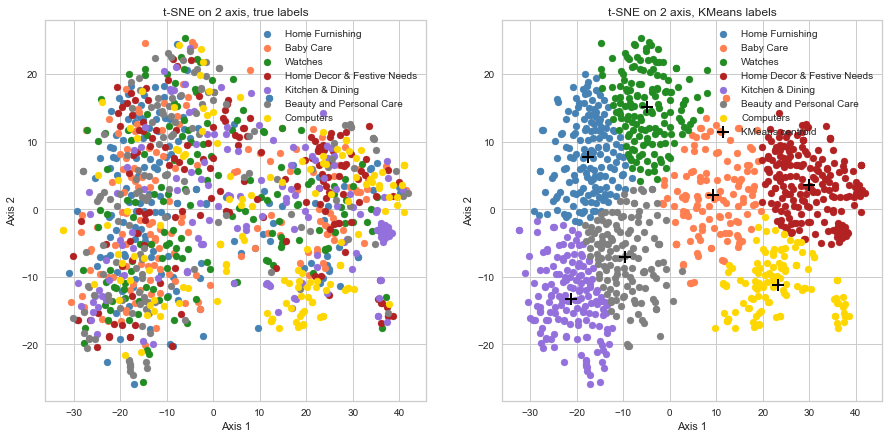

In [43]:
comparison_graph_categories_cv(tsne_results_orb_base, results_computer_vision["category_tree1"], 2, categories,
    results_computer_vision["img_kmeans_labels_orb_tsne2_names"], kmeans_orb_base.cluster_centers_)

The ARI score are very very low. We will look for better parameters.
#### `WTA_K= 4`, 10 t-SNE components

We have a total of 520321 descriptors. Each descriptor is a vector with 32 values.
We will use 721 clusters to group the descriptors.
Mini Batch KMeans fit time : 47.85s.
Computed 1050 histograms of length 721.
KMeans fit time : 0.22s.


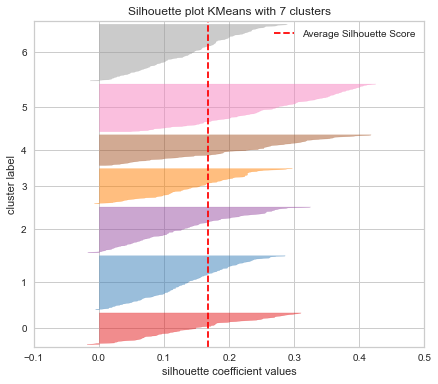

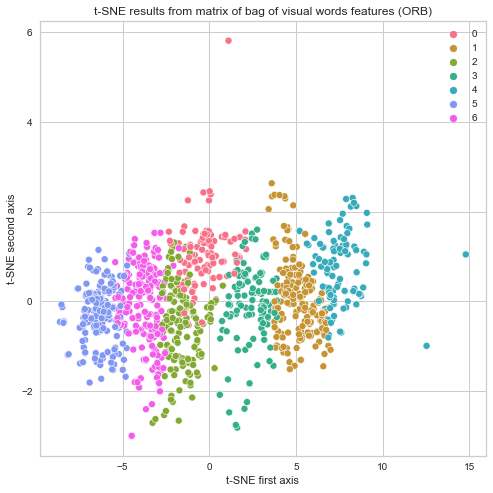

In [44]:
histo_orb_refined, kmeans_orb_refined, tsne_orb_refined = ORB_hist_tsne(img_orb, 7, WTA_K=4, n_comp=10, method="exact", 
    learning_rate=10, perplexity=20, random_state=0)

In [45]:
categories_comparison(results_computer_vision, "img_kmeans_labels_orb_refined", kmeans_orb_refined.labels_, "category_tree1")

Cluster 0
Kitchen & Dining              21
Home Decor & Festive Needs    19
Watches                       17
Home Furnishing               16
Computers                     15
Beauty and Personal Care      11
Baby Care                     11
Name: category_tree1, dtype: int64 

Cluster 1
Kitchen & Dining              41
Home Decor & Festive Needs    39
Baby Care                     28
Computers                     27
Watches                       24
Home Furnishing               16
Beauty and Personal Care      13
Name: category_tree1, dtype: int64 

Cluster 2
Home Furnishing               32
Baby Care                     30
Beauty and Personal Care      24
Watches                       21
Home Decor & Festive Needs    19
Computers                     18
Kitchen & Dining              15
Name: category_tree1, dtype: int64 

Cluster 3
Kitchen & Dining              27
Watches                       24
Home Decor & Festive Needs    22
Baby Care                     18
Computers               

In [48]:
cat_names = ["Home Furnishing", "Home Decor & Festive Needs", "Beauty and Personal Care", "Watches", "Kitchen & Dining", 
    "Computers", "Baby Care"]

clusters_to_true_labels(results_computer_vision, "img_kmeans_labels_orb_refined", "img_kmeans_labels_orb_refined_names", cat_names)

In [49]:
ari_orb_tsne_refined = adjusted_rand_score(results_computer_vision["category_tree1"], 
    results_computer_vision["img_kmeans_labels_orb_refined_names"])
print(f"The adjusted rand score is {ari_orb_tsne_refined:.2f}.")

The adjusted rand score is 0.02.


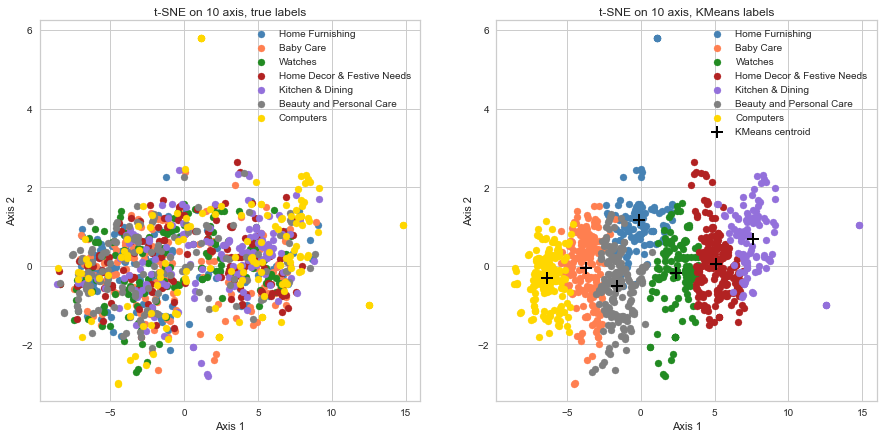

In [51]:
comparison_graph_categories_cv(tsne_orb_refined, results_computer_vision["category_tree1"], 10, categories,
    results_computer_vision["img_kmeans_labels_orb_refined_names"], kmeans_orb_refined.cluster_centers_)

Always bad results...
#### `WTA_K=2`, 10 t-SNE components

We have a total of 520321 descriptors. Each descriptor is a vector with 32 values.
We will use 721 clusters to group the descriptors.
Mini Batch KMeans fit time : 53.18s.
Computed 1050 histograms of length 721.
KMeans fit time : 0.21s.


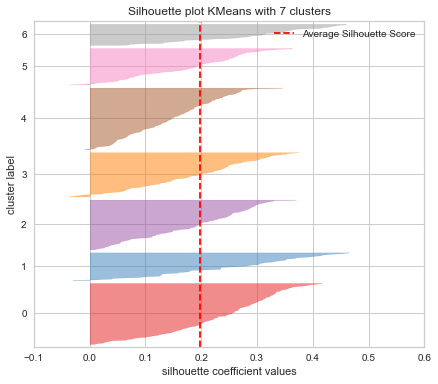

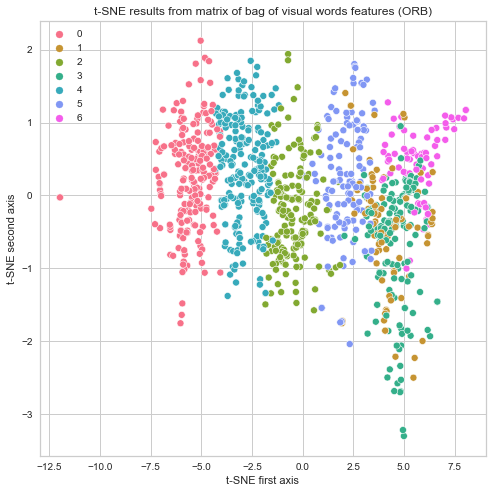

In [52]:
histo_orb_refined2, kmeans_orb_refined2, tsne_orb_refined2 = ORB_hist_tsne(img_orb, 7, n_comp=10, method="exact", 
learning_rate=10, perplexity=20, random_state=0)

In [53]:
categories_comparison(results_computer_vision, "img_kmeans_labels_orb_refined2", kmeans_orb_refined2.labels_, "category_tree1")

Cluster 0
Baby Care                     43
Beauty and Personal Care      42
Watches                       31
Home Furnishing               28
Computers                     23
Kitchen & Dining              23
Home Decor & Festive Needs    22
Name: category_tree1, dtype: int64 

Cluster 1
Computers                     50
Kitchen & Dining              15
Home Furnishing               12
Baby Care                      9
Home Decor & Festive Needs     5
Watches                        3
Beauty and Personal Care       2
Name: category_tree1, dtype: int64 

Cluster 2
Beauty and Personal Care      38
Home Decor & Festive Needs    30
Watches                       29
Kitchen & Dining              28
Home Furnishing               20
Computers                     16
Baby Care                     12
Name: category_tree1, dtype: int64 

Cluster 3
Home Decor & Festive Needs    48
Baby Care                     24
Kitchen & Dining              23
Beauty and Personal Care      19
Computers               

In [54]:
cat_names = ["Watches", "Home Furnishing", "Baby Care", "Computers", "Beauty and Personal Care",
    "Kitchen & Dining", "Home Decor & Festive Needs"]

clusters_to_true_labels(results_computer_vision, "img_kmeans_labels_orb_refined2", 
    "img_kmeans_labels_orb_refined2_names", cat_names)

In [56]:
ari_orb_tsne_refined2 = adjusted_rand_score(results_computer_vision["category_tree1"], 
    results_computer_vision["img_kmeans_labels_orb_refined2_names"])
print(f"The adjusted rand score is {ari_orb_tsne_refined2:.2f}.")

The adjusted rand score is 0.04.


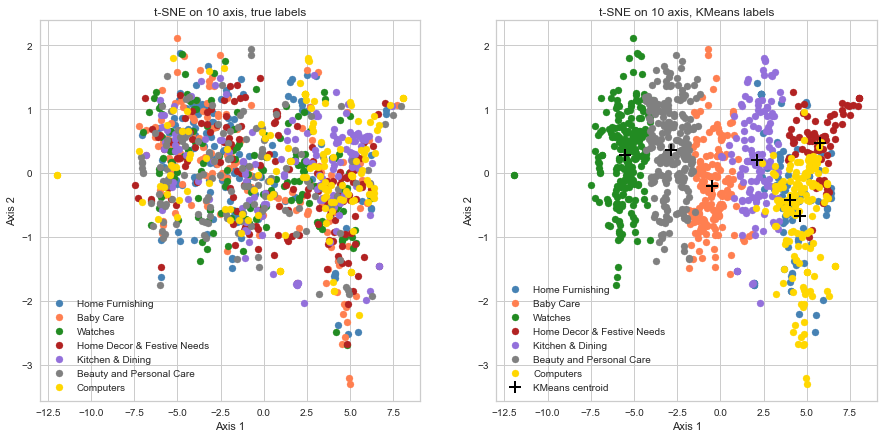

In [58]:
comparison_graph_categories_cv(tsne_orb_refined2, results_computer_vision["category_tree1"], 10, categories,
    results_computer_vision["img_kmeans_labels_orb_refined2_names"], kmeans_orb_refined2.cluster_centers_)

#### `WTA_K=3`, `nfeatures=1000`, 5 t-SNE components...Still very low ARI. 

We have a total of 1032906 descriptors. Each descriptor is a vector with 32 values.
We will use 1016 clusters to group the descriptors.
Mini Batch KMeans fit time : 91.37s.
Computed 1050 histograms of length 1016.
KMeans fit time : 0.22s.


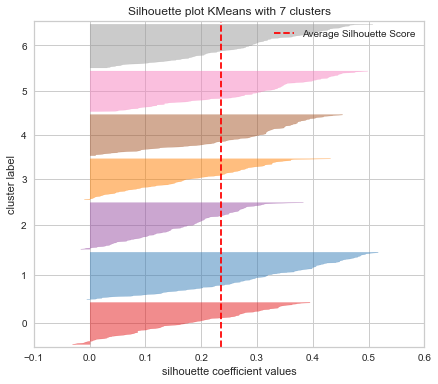

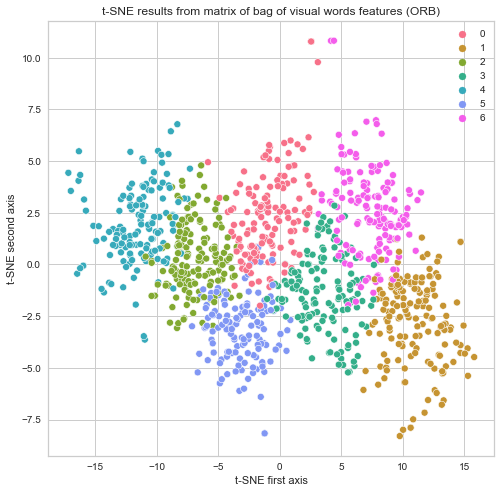

In [59]:
histo_orb_refined3, kmeans_orb_refined3, tsne_orb_refined3 = ORB_hist_tsne(img_orb, 7, nfeatures=1000, WTA_K=3, 
n_comp=5, method="exact", learning_rate=10, random_state=0)

In [60]:
categories_comparison(results_computer_vision, "img_kmeans_labels_orb_refined3", kmeans_orb_refined3.labels_, "category_tree1")

Cluster 0
Home Furnishing               30
Kitchen & Dining              29
Computers                     22
Baby Care                     20
Home Decor & Festive Needs    20
Watches                       18
Beauty and Personal Care       7
Name: category_tree1, dtype: int64 

Cluster 1
Computers                     57
Kitchen & Dining              44
Home Furnishing               16
Watches                       15
Baby Care                     13
Beauty and Personal Care      10
Home Decor & Festive Needs     9
Name: category_tree1, dtype: int64 

Cluster 2
Home Furnishing               43
Beauty and Personal Care      33
Baby Care                     32
Home Decor & Festive Needs    18
Watches                       14
Computers                     11
Kitchen & Dining              11
Name: category_tree1, dtype: int64 

Cluster 3
Watches                       39
Kitchen & Dining              25
Baby Care                     21
Computers                     16
Beauty and Personal Care

In [61]:
cat_names = ["Beauty and Personal Care", "Computers", "Kitchen & Dining", "Watches", "Home Furnishing", 
    "Baby Care", "Home Decor & Festive Needs"]

clusters_to_true_labels(results_computer_vision, "img_kmeans_labels_orb_refined3", 
    "img_kmeans_labels_orb_refined3_names", cat_names)

In [63]:
ari_orb_tsne_refined3 = adjusted_rand_score(results_computer_vision["category_tree1"], 
    results_computer_vision["img_kmeans_labels_orb_refined3_names"])
print(f"The adjusted rand score is {ari_orb_tsne_refined3:.2f}.")

The adjusted rand score is 0.04.


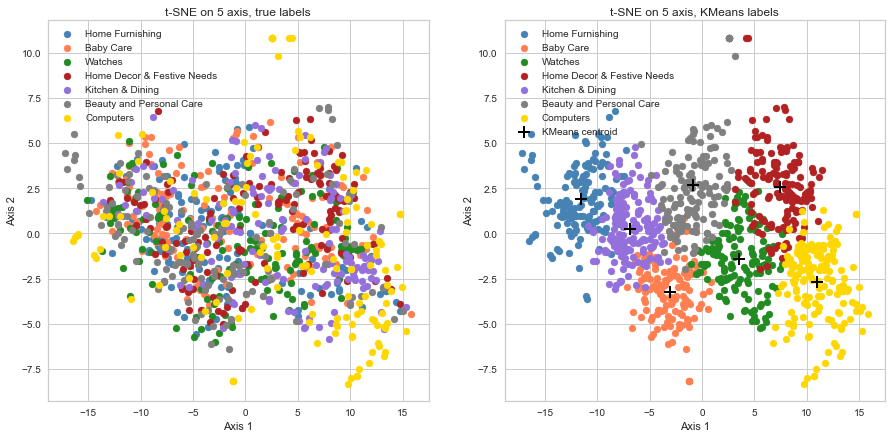

In [65]:
comparison_graph_categories_cv(tsne_orb_refined3, results_computer_vision["category_tree1"], 5, categories,
    results_computer_vision["img_kmeans_labels_orb_refined3_names"], kmeans_orb_refined3.cluster_centers_)

Even when playing with parameters, the ORB approach do not give very good results. 

Now We can try to combine NLP and computer vision features, or look for neural network approaches.

## Use both NLP and computer vision to categorized products

### With t-SNE dimensions

We will use the 3 t-SNE axis from word2vec pre-trained model and the t-SNE dimensions obtained from ORB descriptors and histograms together with a KMeans clustering.

In [68]:
nlp_cv_features = pd.concat([w2v_gn300_tsne[["axis_1", "axis_2", "axis_3"]], tsne_results_orb_base[["axis_1", "axis_2"]]], axis=1)

In [69]:
nlp_cv_features.head()

,axis_1,axis_2,axis_3,axis_1,axis_2
0,-14.640857,-3.689599,3.120446,-9.058819,8.130949
1,-11.966592,8.012860,4.443799,17.947412,2.827380
2,-10.338565,8.081668,3.946836,-9.511458,1.205796
3,-10.298294,4.004013,7.119347,-19.475744,15.772126
4,-10.193836,3.951613,6.233512,-16.619535,7.514725


In [70]:
t0 = time()
kmeans_all = KMeans(n_clusters=7,random_state=0).fit(nlp_cv_features)
t1 = time()-t0
print(f"KMeans fit time : {t1:.2f}s.")

KMeans fit time : 3.52s.


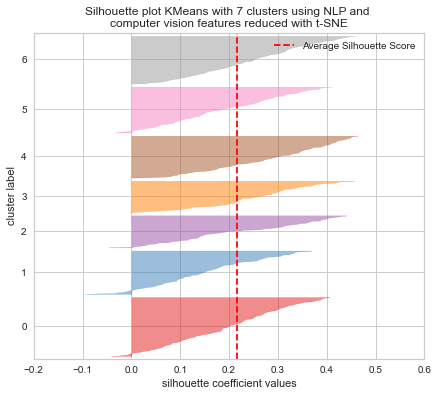

In [71]:
fig, ax = plt.subplots(figsize=(7, 6))
visualizer = SilhouetteVisualizer(KMeans(7, random_state=0),
    title='Silhouette plot KMeans with 7 clusters using NLP and \ncomputer vision features reduced with t-SNE')
visualizer.fit(nlp_cv_features)
visualizer.finalize()

In [72]:
# t_SNE dimensions reduction and visualization
tsne_results_all = TSNE(n_components=2, init="pca", learning_rate=50, n_jobs=-2, random_state=0).fit_transform(nlp_cv_features)

nlp_cv_features["labels"] = kmeans_all.labels_
tsne_results_all = pd.DataFrame(tsne_results_all)

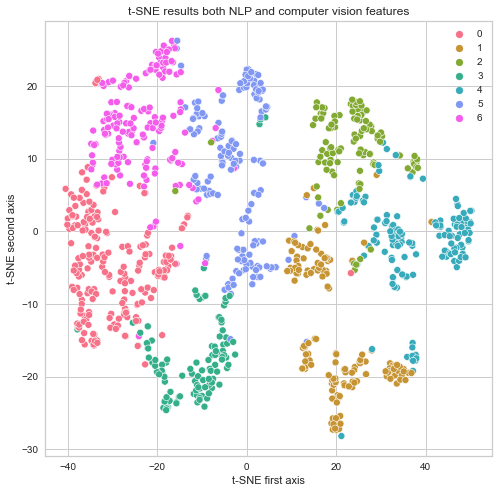

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, x=tsne_results_all[0], y=tsne_results_all[1], hue=nlp_cv_features["labels"], palette=sns.color_palette("husl", 7))
ax.set_title("t-SNE results both NLP and computer vision features")
ax.set_xlabel("t-SNE first axis")
ax.set_ylabel("t-SNE second axis")
ax.legend();

In [74]:
categories_comparison(results_computer_vision, "nlp_img_kmeans_labels", kmeans_all.labels_, "category_tree1")

Cluster 0
Baby Care                     60
Home Furnishing               48
Beauty and Personal Care      40
Kitchen & Dining              32
Home Decor & Festive Needs    21
Computers                      3
Watches                        1
Name: category_tree1, dtype: int64 

Cluster 1
Computers                     90
Watches                       47
Kitchen & Dining              10
Home Decor & Festive Needs     3
Beauty and Personal Care       1
Name: category_tree1, dtype: int64 

Cluster 2
Baby Care                     49
Home Furnishing               30
Beauty and Personal Care      20
Kitchen & Dining              10
Home Decor & Festive Needs     3
Name: category_tree1, dtype: int64 

Cluster 3
Watches                       58
Computers                     23
Beauty and Personal Care      23
Home Decor & Festive Needs     4
Baby Care                      1
Home Furnishing                1
Name: category_tree1, dtype: int64 

Cluster 4
Home Decor & Festive Needs    59
Kitchen & 

In [75]:
cat_names = ["Home Decor & Festive Needs", "Baby Care", "Beauty and Personal Care", "Computers", "Home Furnishing", 
    "Watches", "Kitchen & Dining"]

clusters_to_true_labels(results_computer_vision, "nlp_img_kmeans_labels", "nlp_img_kmeans_labels_names", cat_names)

In [77]:
ari_all = adjusted_rand_score(results_computer_vision["category_tree1"], results_computer_vision["nlp_img_kmeans_labels_names"])
print(f"The adjusted rand score is {ari_all:.2f}.")

The adjusted rand score is 0.17.


Although we combine features, we got a low result, probably because of the misleading ORB features.
### Using raw NLP and computer vision features
We will merge word-embedding features (mean documents vectors) and images histograms.

In [80]:
best_raw_features = pd.concat([pd.DataFrame(all_doc_vec_gn300), pd.DataFrame(histograms_orb_base)], axis=1)
best_raw_features

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,0.042894,0.045476,-0.006150,0.030052,-0.028071,-0.050948,0.100145,-0.144734,0.072347,0.133723,...,0.006,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.002,0.000
1,0.027648,0.068713,0.016509,0.068324,-0.004316,0.036095,0.052063,-0.210133,0.050617,0.114142,...,0.000,0.000,0.002,0.004,0.000,0.000,0.000,0.000,0.000,0.000
2,0.016117,0.095866,-0.001201,0.065921,-0.012179,0.045052,0.088026,-0.113299,0.083913,0.132010,...,0.000,0.002,0.006,0.000,0.002,0.004,0.004,0.000,0.000,0.000
3,0.004830,0.041097,-0.042803,0.084351,-0.009427,-0.024091,0.079291,-0.142121,0.070222,0.091875,...,0.002,0.000,0.000,0.006,0.002,0.002,0.000,0.000,0.000,0.000
4,0.008379,0.041414,0.008116,0.074180,0.015057,-0.013216,0.103658,-0.100464,0.058809,0.078448,...,0.000,0.000,0.002,0.000,0.004,0.004,0.004,0.002,0.000,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.002669,0.054524,0.006401,0.047329,-0.077869,-0.004501,0.089813,-0.071760,0.069989,0.072693,...,0.000,0.002,0.002,0.000,0.000,0.000,0.002,0.000,0.000,0.000
1046,0.020952,0.057235,0.008301,0.052461,-0.035763,-0.000526,0.097028,-0.105765,0.072324,0.087733,...,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000
1047,0.051991,0.129019,-0.037107,0.115834,-0.039634,0.041309,0.062358,-0.188838,0.082241,0.089719,...,0.004,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000
1048,0.099506,0.094223,0.035084,0.209394,-0.043640,0.074844,0.157867,-0.138744,0.192291,0.090588,...,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.002,0.002,0.000


We have 1021 features. We need to scale our features first.

In [81]:
raw_features_scaled = StandardScaler().fit_transform(best_raw_features)
t0 = time()
kmeans_raw_features = KMeans(n_clusters=7,random_state=0).fit(raw_features_scaled)
t1 = time()-t0
print(f"KMeans fit time : {t1:.2f}s.")

KMeans fit time : 5.35s.


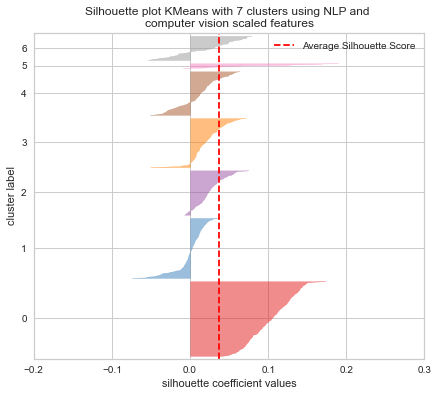

In [82]:
fig, ax = plt.subplots(figsize=(7, 6))
visualizer = SilhouetteVisualizer(KMeans(7, random_state=0),
    title='Silhouette plot KMeans with 7 clusters using NLP and \ncomputer vision scaled features')
visualizer.fit(raw_features_scaled)
visualizer.finalize()

In [83]:
# t_SNE dimensions reduction and visualization
tsne_results_raw_features = TSNE(n_components=2, init="pca", learning_rate=50, n_jobs=-2, random_state=0).fit_transform(raw_features_scaled)

tsne_results_raw_features = pd.DataFrame(tsne_results_raw_features)
tsne_results_raw_features["kmeans_labels"] = kmeans_raw_features.labels_

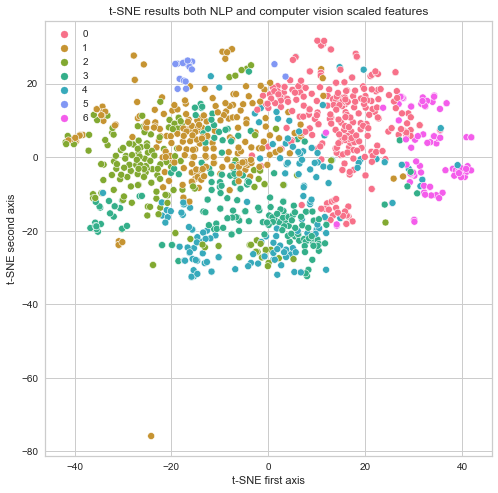

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, x=tsne_results_raw_features[0], y=tsne_results_raw_features[1], 
    hue=tsne_results_raw_features["kmeans_labels"], palette=sns.color_palette("husl", 7))
ax.set_title("t-SNE results both NLP and computer vision scaled features")
ax.set_xlabel("t-SNE first axis")
ax.set_ylabel("t-SNE second axis")
ax.legend();

In [85]:
categories_comparison(results_computer_vision, "nlp_img_raw_kmeans_labels", kmeans_raw_features.labels_, "category_tree1")

Cluster 0
Kitchen & Dining              63
Home Decor & Festive Needs    60
Baby Care                     42
Beauty and Personal Care      26
Watches                       25
Home Furnishing               25
Computers                     19
Name: category_tree1, dtype: int64 

Cluster 1
Home Furnishing               73
Baby Care                     56
Kitchen & Dining              36
Home Decor & Festive Needs    27
Beauty and Personal Care      15
Computers                      2
Name: category_tree1, dtype: int64 

Cluster 2
Home Furnishing               39
Home Decor & Festive Needs    29
Baby Care                     28
Beauty and Personal Care      21
Watches                       15
Kitchen & Dining              15
Computers                      8
Name: category_tree1, dtype: int64 

Cluster 3
Watches                       62
Beauty and Personal Care      44
Computers                     27
Baby Care                     14
Kitchen & Dining              14
Home Decor & Festive Nee

In [86]:
cat_names = ["Kitchen & Dining", "Baby Care", "Home Furnishing", "Home Decor & Festive Needs", "Watches", "Computers",  
    "Beauty and Personal Care"]

clusters_to_true_labels(results_computer_vision, "nlp_img_raw_kmeans_labels", "nlp_img_raw_kmeans_labels_names", cat_names)

In [88]:
ari_all = adjusted_rand_score(results_computer_vision["category_tree1"], results_computer_vision["nlp_img_raw_kmeans_labels_names"])
print(f"The adjusted rand score is {ari_all:.2f}.")

The adjusted rand score is 0.11.


The categorization is still not very successfull...
### Raw features with a PCA before KMeans

In [89]:
raw_features_scaled_df = pd.DataFrame(raw_features_scaled)

In [90]:
n_comp = 600

X = raw_features_scaled_df.values
noms = raw_features_scaled_df.index
features = raw_features_scaled_df.columns

# Main axes calculation
acp = PCA(n_components=n_comp)
acp.fit(X)

PCA(n_components=600)

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

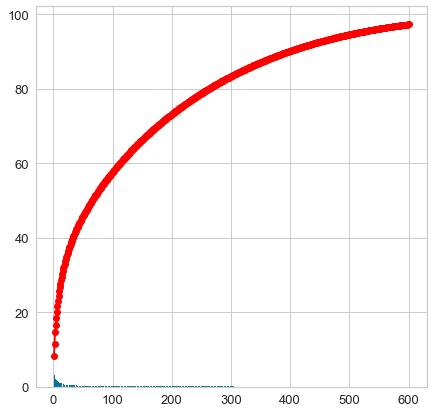

In [91]:
display_eigenvalues(acp, annotate=False)

We will keep coordinates on 600 PCA axis as features, which give us close to 99% of the original information.

In [92]:
raw_features_reduced = acp.transform(raw_features_scaled_df)

In [93]:
pd.DataFrame(raw_features_reduced)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-7.729361,5.775435,0.885797,2.147493,-1.097941,-2.375733,-6.191534,2.191283,1.497865,2.925035,...,0.212146,0.283969,-0.161831,-0.768226,0.450708,-0.130825,0.197735,0.205001,0.198892,0.025644
1,4.103042,3.987062,8.704988,3.588360,-0.615897,2.509498,2.979199,-5.181199,0.206165,-0.384546,...,-0.263302,0.162692,0.256271,-0.320154,0.756318,0.132799,-0.533016,0.565763,-0.874513,0.522237
2,-6.828182,-0.305792,3.837528,1.051831,0.330895,0.891518,-1.505032,-1.330650,7.948132,7.120879,...,-0.309647,-0.224673,0.008039,-0.274486,-0.370492,-0.104420,-0.361294,0.013676,0.416923,-0.296425
3,-7.700594,9.405211,2.532579,4.728592,2.105074,2.849825,3.925186,-2.022583,-1.948589,5.123475,...,-0.091163,-0.039341,-0.894169,0.618906,0.547126,0.087930,-0.322780,0.421190,0.114972,-0.105213
4,-10.532654,-0.110321,4.210653,2.752173,1.812309,2.082295,3.266899,-1.956602,-2.764659,3.997549,...,0.526487,-0.427286,-0.516048,0.365080,-0.545695,0.611295,-0.157593,0.276468,0.097744,0.122283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-6.796451,-3.763154,1.839001,-1.371961,0.062048,-5.488309,-4.965466,-0.827042,-1.426357,1.216149,...,0.021622,0.325124,0.418504,0.302722,-0.099333,0.662101,0.443384,0.091613,-0.226147,-0.143605
1046,-6.713967,-5.217779,-0.390781,-1.960745,-0.665769,-6.562986,-6.267691,-0.523898,-1.674802,0.558811,...,-0.261907,-0.607927,0.331772,0.608733,-0.209061,0.489216,0.366081,0.135169,-0.052821,-0.696082
1047,-5.380877,-4.235524,1.266869,-2.431207,2.226030,-4.434189,-1.989364,-1.142392,3.395769,6.346589,...,-0.395651,-0.028688,-0.180425,0.571510,-0.477665,-0.389164,-0.570023,0.726222,0.169204,-0.172330
1048,-6.236932,-11.021428,2.025023,0.113735,2.866976,-5.184290,-3.275556,3.181030,-2.258772,2.109399,...,0.442255,0.316652,0.020522,-0.891789,0.359202,-0.043323,-0.639790,0.672618,0.129347,-0.401342


In [94]:
t0 = time()
kmeans_raw_features_reduced = KMeans(n_clusters=7,random_state=0).fit(raw_features_reduced)
t1 = time()-t0
print(f"KMeans fit time : {t1:.2f}s.")

KMeans fit time : 5.54s.


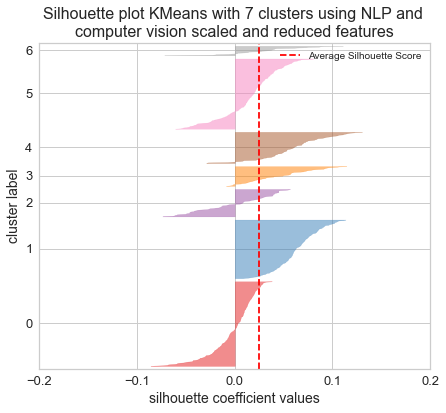

In [95]:
fig, ax = plt.subplots(figsize=(7, 6))
visualizer = SilhouetteVisualizer(KMeans(7, random_state=0),
    title='Silhouette plot KMeans with 7 clusters using NLP and \ncomputer vision scaled and reduced features')
visualizer.fit(raw_features_reduced)
visualizer.finalize()

In [96]:
# t_SNE dimensions reduction and visualization
tsne_results_raw_features_reduced = TSNE(n_components=2, init="pca", learning_rate=50, n_jobs=-2, random_state=0).fit_transform(raw_features_reduced)

tsne_results_raw_features_reduced = pd.DataFrame(tsne_results_raw_features_reduced)
tsne_results_raw_features_reduced["kmeans_labels"] = kmeans_raw_features_reduced.labels_

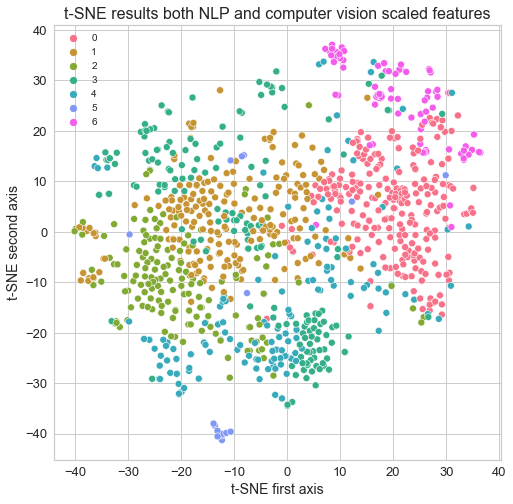

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, x=tsne_results_raw_features_reduced[0], y=tsne_results_raw_features_reduced[1], 
    hue=tsne_results_raw_features["kmeans_labels"], palette=sns.color_palette("husl", 7))
ax.set_title("t-SNE results both NLP and computer vision scaled features")
ax.set_xlabel("t-SNE first axis")
ax.set_ylabel("t-SNE second axis")
ax.legend();

In [98]:
categories_comparison(results_computer_vision, "nlp_img_raw_reduced_kmeans_labels", 
    kmeans_raw_features_reduced.labels_, "category_tree1")

Cluster 0
Baby Care                     69
Beauty and Personal Care      60
Home Furnishing               50
Kitchen & Dining              49
Home Decor & Festive Needs    34
Computers                     26
Watches                        6
Name: category_tree1, dtype: int64 

Cluster 1
Kitchen & Dining              62
Baby Care                     43
Home Furnishing               28
Beauty and Personal Care      27
Watches                       23
Home Decor & Festive Needs    11
Computers                     10
Name: category_tree1, dtype: int64 

Cluster 2
Computers                     90
Kitchen & Dining               4
Beauty and Personal Care       1
Home Decor & Festive Needs     1
Name: category_tree1, dtype: int64 

Cluster 3
Home Decor & Festive Needs    59
Kitchen & Dining               8
Beauty and Personal Care       2
Name: category_tree1, dtype: int64 

Cluster 4
Watches                       101
Computers                       6
Home Decor & Festive Needs      2
Name: c

In [99]:
cat_names = ["Watches", "Home Furnishing", "Computers", "Kitchen & Dining", "Beauty and Personal Care", 
    "Baby Care", "Home Decor & Festive Needs"]

clusters_to_true_labels(results_computer_vision, "nlp_img_raw_reduced_kmeans_labels", 
    "nlp_img_raw_reduced_kmeans_labels_names", cat_names)

In [100]:
ari_raw_reduced = adjusted_rand_score(results_computer_vision["category_tree1"], results_computer_vision["nlp_img_raw_reduced_kmeans_labels"])
print(f"The adjusted rand score is {ari_raw_reduced:.2f}.")

The adjusted rand score is 0.16.


Not better with CPA before...

## Supervised approach for computer vision: VGG16 neural network
We will preprocess images by adding a white border and resize images so that the aspect ratio will be preserved.

In [101]:
def preprocess_resize(images, final_size, border_color):
    """
    """
    images_final = []

    for i, img in enumerate(images):
        height = images[i].shape[0]
        width = images[i].shape[1]

        if height == width:
            img_border = images[i]
        elif height > width:
            border = round((height - width) / 2)
            img_border = cv2.copyMakeBorder(images[i], 0, 0, border, border, 
                                            cv2.BORDER_CONSTANT, None, value = border_color)
        else:
            border = round((width - height) / 2)
            img_border = cv2.copyMakeBorder(images[i], border, border, 0, 0, 
                                            cv2.BORDER_CONSTANT, None, value = border_color)
        
        img_resized = cv2.resize(img_border, final_size, interpolation = cv2.INTER_AREA)
        images_final.append(img_resized)
    
    images_final = np.asarray(images_final)

    return images_final

In [102]:
# Pre-processing images by resizing and formatting for tensorflow
img_resized = preprocess_resize(img_base, (224, 224), (255, 255, 255))
img_inputs = vgg16.preprocess_input(img_resized)

In [105]:
# Creating directories for training, validation and test sets
train_dir = "trainings"
validation_dir = "validationss"
test_dir = "tests"

train_path = os.path.join(file_path, train_dir)
validation_path = os.path.join(file_path, validation_dir)
test_path = os.path.join(file_path, test_dir)

os.mkdir(train_path)
os.mkdir(validation_path)
os.mkdir(test_path)

In [106]:
# Creating categories directories
categories_short = ["furnishing", "baby", "watches", "decor", "kitchen", "beauty", "computers"]

for name in categories_short:
    cat_path_train = os.path.join(train_path, name)
    cat_path_val = os.path.join(validation_path, name)
    cat_path_test = os.path.join(test_path, name)
    os.mkdir(cat_path_train)
    os.mkdir(cat_path_val)
    os.mkdir(cat_path_test)

In [107]:
# Create path names
path_train_furnishing = os.path.join(train_path, "furnishing")
path_train_baby = os.path.join(train_path, "baby")
path_train_watches = os.path.join(train_path, "watches")
path_train_decor = os.path.join(train_path, "decor")
path_train_kitchen = os.path.join(train_path, "kitchen")
path_train_beauty = os.path.join(train_path, "beauty")
path_train_computers = os.path.join(train_path, "computers")

path_validation_furnishing = os.path.join(validation_path, "furnishing")
path_validation_baby = os.path.join(validation_path, "baby")
path_validation_watches = os.path.join(validation_path, "watches")
path_validation_decor = os.path.join(validation_path, "decor")
path_validation_kitchen = os.path.join(validation_path, "kitchen")
path_validation_beauty = os.path.join(validation_path, "beauty")
path_validation_computers = os.path.join(validation_path, "computers")

path_test_furnishing = os.path.join(test_path, "furnishing")
path_test_baby = os.path.join(test_path, "baby")
path_test_watches = os.path.join(test_path, "watches")
path_test_decor = os.path.join(test_path, "decor")
path_test_kitchen = os.path.join(test_path, "kitchen")
path_test_beauty = os.path.join(test_path, "beauty")
path_test_computers = os.path.join(test_path, "computers")

In [109]:
# Sort images in lists depending on their true categories
images_furnishing = []
images_baby = []
images_watches = []
images_decor = []
images_kitchen = []
images_beauty = []
images_computers = []

for i, image in enumerate(img_resized):
    if results_computer_vision.loc[i, :]["category_tree1"]=="Home Furnishing":
        images_furnishing.append(image)
    elif results_computer_vision.loc[i, :]["category_tree1"]=="Baby Care":
        images_baby.append(image)
    elif results_computer_vision.loc[i, :]["category_tree1"]=="Watches":
        images_watches.append(image)
    elif results_computer_vision.loc[i, :]["category_tree1"]=="Home Decor & Festive Needs":
        images_decor.append(image)
    elif results_computer_vision.loc[i, :]["category_tree1"]=="Kitchen & Dining":
        images_kitchen.append(image)
    elif results_computer_vision.loc[i, :]["category_tree1"]=="Beauty and Personal Care":
        images_beauty.append(image)
    else:
        images_computers.append(image)

In [110]:
def write_images_in_folders(list_images, slice_begining, slice_end, root_names, paths_list):
    """
    Make folder according to categories.
    """
    for list_img, root_name, path in zip(list_images, root_names, paths_list):
        for i, image in enumerate (list_img[slice_begining:slice_end]):
            name = root_name + str(i) + ".jpg"
            new_img_path = os.path.join(path, name)
            cv2.imwrite(new_img_path, list_img[slice_begining+i])

In [111]:
# Split images into train, validation and test sets
images_all_cat = [images_furnishing, images_baby, images_watches, images_decor, images_kitchen, 
    images_beauty, images_computers]
root_names = ["furnishing_", "baby_", "watches_", "decor_", "kitchen_", "beauty_", "computers_"]

all_paths_train = [path_train_furnishing, path_train_baby, path_train_watches, path_train_decor,
    path_train_kitchen, path_train_beauty, path_train_computers]
all_paths_validation = [path_validation_furnishing, path_validation_baby, path_validation_watches, path_validation_decor,
    path_validation_kitchen, path_validation_beauty, path_validation_computers]
all_paths_test = [path_test_furnishing, path_test_baby, path_test_watches, path_test_decor,
    path_test_kitchen, path_test_beauty, path_test_computers]

write_images_in_folders(images_all_cat, 0, 110, root_names, all_paths_train)
write_images_in_folders(images_all_cat, 110, 130, root_names, all_paths_validation)
write_images_in_folders(images_all_cat, 130, 150, root_names, all_paths_test)

### Basic pre-trained VGG16

First we use the pre-trained VGG16 as is with the 1000 pre-defined classes.

In [112]:
#Define model and make predictions
vgg16_basic = tf.keras.applications.VGG16()
vgg16_basic_proba = vgg16_basic.predict(img_inputs)

In [113]:
# Add a column with predicted classes
results_computer_vision["n_img"] = results_computer_vision.index
results_computer_vision["vgg16_basic"] = results_computer_vision["n_img"].apply(
    lambda x: vgg16.decode_predictions(vgg16_basic_proba, top=1)[x][0][1])

40960/35363 [==================================] - 0s 0us/step


The top 1 predicted classes of VGG 16 for the first 10 images:

In [114]:
results_computer_vision["vgg16_basic"][:10]

0           binder
1       bath_towel
2             wool
3     studio_couch
4            quilt
5    digital_watch
6     analog_clock
7     analog_clock
8    digital_watch
9     analog_clock
Name: vgg16_basic, dtype: object

We could use these classes for classification, or group them into our 7 classes.
### Features extraction
We will use the VGG16 model without top layers and extract output features from the last pooling layer.

# Define our extraction model
vgg16_extraction = tf.keras.applications.VGG16(weights="imagenet", include_top=False)

In [115]:
# Define our extraction model
vgg16_extraction = tf.keras.applications.VGG16(weights="imagenet", include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [116]:
# Predict from our images
vgg16_features = vgg16_extraction.predict(img_inputs)

In [117]:
# Get the features from the weights of the 7 x 7 x 152 layer
vgg16_features_array = []

for i, features in enumerate(vgg16_features):
    features = np.array(vgg16_features[i])
    vgg16_features_array.append(features.flatten())

In [118]:
# Our features in a dataframe
vgg16_features_last_pool = pd.DataFrame(vgg16_features_array)
vgg16_features_last_pool

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,5.843289,0.000000,0.0,0.0,0.0,0.0,...,15.248774,48.304771,0.0,0.000000,0.0,19.737257,5.516457,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,2.131098,0.0,0.000000,0.000000,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.000000,1.079704,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,9.549871,0.000000,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


We have more than 25000 features, we need to perform a dimensions reduction. We will keep the first 800 components from a CPA reduction.

In [119]:
n_comp = 800

X = vgg16_features_last_pool.values
noms = vgg16_features_last_pool.index
features = vgg16_features_last_pool.columns

# Main axes calculation
acp = PCA(n_components=n_comp)
acp.fit(X)

PCA(n_components=800)

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

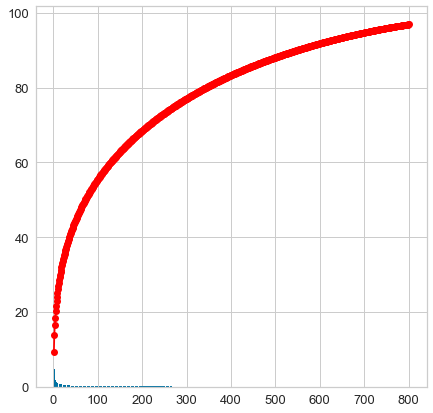

In [120]:
display_eigenvalues(acp, annotate=False)

In [121]:
# Get our transformed features
vgg16_features_last_pool_reduced = acp.transform(vgg16_features_last_pool)

In [122]:
# Use our features in the KMeans
t0 = time()
kmeans_vgg16_features_last_pool_reduced = KMeans(n_clusters=7,random_state=0).fit(vgg16_features_last_pool_reduced)
t1 = time()-t0
print(f"KMeans fit time : {t1:.2f}s.")

KMeans fit time : 5.28s.


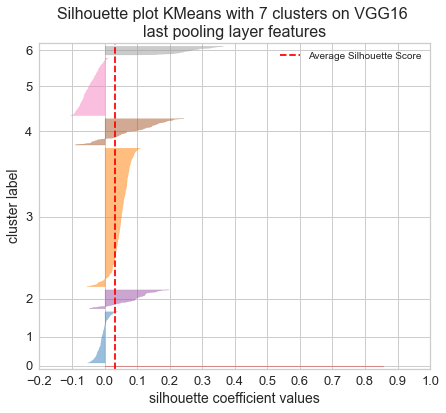

In [123]:
fig, ax = plt.subplots(figsize=(7, 6))
visualizer = SilhouetteVisualizer(KMeans(7, random_state=0),
    title='Silhouette plot KMeans with 7 clusters on VGG16 \nlast pooling layer features')
visualizer.fit(vgg16_features_last_pool_reduced)
visualizer.finalize()

The results do not seem well balanced between clusters...

In [124]:
# t_SNE dimensions reduction and visualization
tsne_results_vgg16_features_last_pool = TSNE(n_components=3, init="pca", learning_rate=10, perplexity=10, n_jobs=-2, random_state=0).fit_transform(vgg16_features_last_pool_reduced)

tsne_results_vgg16_features_last_pool = pd.DataFrame(tsne_results_vgg16_features_last_pool)
tsne_results_vgg16_features_last_pool.rename(columns={0:"axis_1", 1:"axis_2", 2:"axis_3"}, inplace=True)

tsne_results_vgg16_features_last_pool["kmeans_labels"] = kmeans_vgg16_features_last_pool_reduced.labels_

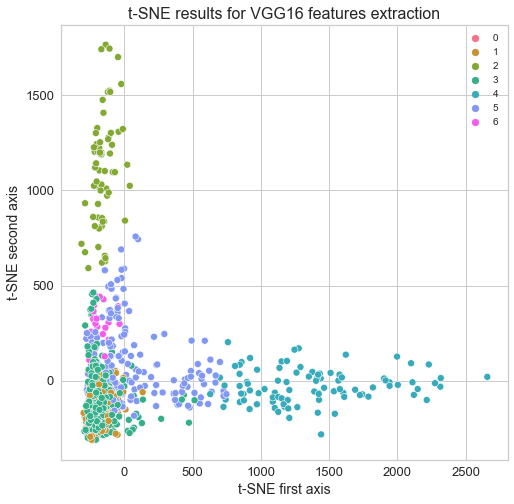

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, x=tsne_results_vgg16_features_last_pool["axis_1"], y=tsne_results_vgg16_features_last_pool["axis_2"], 
    hue=tsne_results_vgg16_features_last_pool["kmeans_labels"], palette=sns.color_palette("husl", 7))
ax.set_title("t-SNE results for VGG16 features extraction")
ax.set_xlabel("t-SNE first axis")
ax.set_ylabel("t-SNE second axis")
ax.legend();

In [126]:
categories_comparison(results_computer_vision, "vgg16_features_extraction_kmeans_labels", 
    kmeans_vgg16_features_last_pool_reduced.labels_, "category_tree1")

Cluster 0
Home Furnishing    2
Name: category_tree1, dtype: int64 

Cluster 1
Baby Care                     92
Home Furnishing               65
Home Decor & Festive Needs    16
Beauty and Personal Care       3
Computers                      2
Name: category_tree1, dtype: int64 

Cluster 2
Beauty and Personal Care    64
Kitchen & Dining             1
Computers                    1
Name: category_tree1, dtype: int64 

Cluster 3
Computers                     141
Home Decor & Festive Needs     93
Home Furnishing                82
Beauty and Personal Care       61
Kitchen & Dining               53
Baby Care                      47
Watches                         4
Name: category_tree1, dtype: int64 

Cluster 4
Watches                       91
Home Decor & Festive Needs     1
Name: category_tree1, dtype: int64 

Cluster 5
Kitchen & Dining              65
Watches                       55
Home Decor & Festive Needs    40
Beauty and Personal Care      22
Baby Care                     11
Compute

In [127]:
cat_names = ["Home Furnishing", "Watches", "Kitchen & Dining", "Beauty and Personal Care", "Baby Care", 
    "Home Decor & Festive Needs",  "Computers"]

clusters_to_true_labels(results_computer_vision, "vgg16_features_extraction_kmeans_labels", 
    "vgg16_features_extraction_kmeans_labels_names", cat_names)

In [129]:
ari_raw_reduced = adjusted_rand_score(results_computer_vision["category_tree1"], results_computer_vision["vgg16_features_extraction_kmeans_labels_names"])
print(f"The adjusted rand score is {ari_raw_reduced:.2f}.")

The adjusted rand score is 0.18.


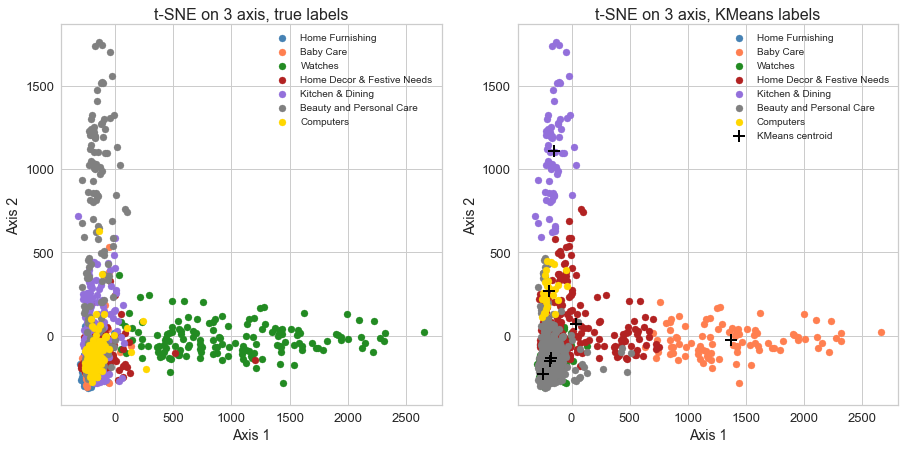

In [130]:
comparison_graph_categories_cv(tsne_results_vgg16_features_last_pool, results_computer_vision["category_tree1"], 3, categories, 
    results_computer_vision["vgg16_features_extraction_kmeans_labels_names"], kmeans_vgg16_features_last_pool_reduced.cluster_centers_)

The score is quite low...
### Replace and train last layers
We will use an optimizer with and average pooling layer and a dense layer.

In [132]:
# Make train and validation sets
train_ds = image_dataset_from_directory(
    directory="Images/trainings",
    labels="inferred",
    label_mode="categorical",
    class_names=categories_short,
    batch_size=32,
    image_size=(224, 224))
validation_ds = image_dataset_from_directory(
    directory="Images/validationss",
    labels="inferred",
    label_mode="categorical",
    class_names=categories_short,
    batch_size=32,
    image_size=(224, 224))

Found 770 files belonging to 7 classes.
Found 140 files belonging to 7 classes.


In [133]:
# Get our base model without top layers
vgg16_notop = tf.keras.applications.VGG16(weights="imagenet", include_top=False)

# Freeze base model layers
for layer in vgg16_notop.layers:
    layer.trainable = False

# Make a pool average and dense output layer for 7 categories, add them to the base model
pool_avg = tf.keras.layers.GlobalAveragePooling2D()(vgg16_notop.output)
output_dense = tf.keras.layers.Dense(units=7, activation="softmax")(pool_avg)
vgg16_modified = tf.keras.Model(inputs=vgg16_notop.input, outputs=output_dense)

In [134]:
# Add the SGD optimizer and compile model
optimizer = tf.keras.optimizers.SGD()
vgg16_modified.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [135]:
vgg16_modified.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [136]:
# Fit model
history = vgg16_modified.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
25/25 [==============================] - 383s 15s/step - loss: 7.4544 - accuracy: 0.4856 - val_loss: 16.9658 - val_accuracy: 0.2500
Epoch 2/5
25/25 [==============================] - 369s 15s/step - loss: 4.0898 - accuracy: 0.7197 - val_loss: 4.2366 - val_accuracy: 0.6000
Epoch 3/5
25/25 [==============================] - 440s 18s/step - loss: 1.0273 - accuracy: 0.8328 - val_loss: 4.2958 - val_accuracy: 0.6500
Epoch 4/5
25/25 [==============================] - 418s 17s/step - loss: 0.6549 - accuracy: 0.8899 - val_loss: 3.6693 - val_accuracy: 0.6429
Epoch 5/5
25/25 [==============================] - 767s 31s/step - loss: 0.4667 - accuracy: 0.9013 - val_loss: 4.1984 - val_accuracy: 0.6357


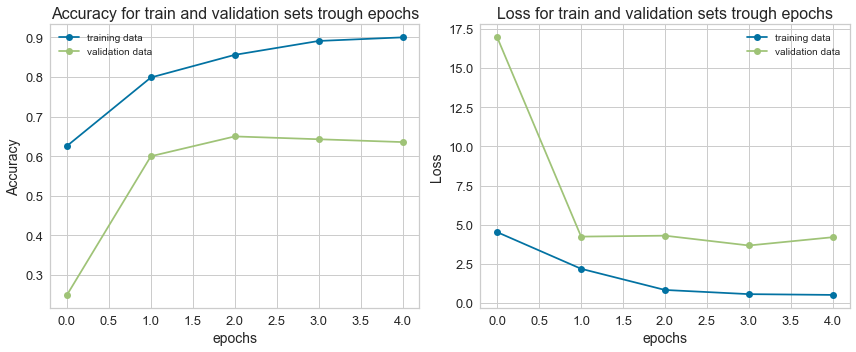

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

ax1.plot(history.history["accuracy"], marker="o", label="training data")
ax1.plot(history.history["val_accuracy"], marker="o", label="validation data")
ax1.set_title("Accuracy for train and validation sets trough epochs")
ax1.set_xlabel("epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(history.history["loss"], marker="o", label="training data")
ax2.plot(history.history["val_loss"], marker="o", label="validation data")
ax2.set_title("Loss for train and validation sets trough epochs")
ax2.set_xlabel("epochs")
ax2.set_ylabel("Loss")
ax2.legend();

In [ ]:
# function that create two varables with same values
def create_var_with_same_value(value, shape):
    var = tf.Variable(value, shape=shape)
    return var

# use 
    